SVM's take a set of n dim vectors will labeled classes, e.g. standard scalar rates of output for each trial. 
you then have different choices of kernel, can check all of these
regularization values are tuneable


In [2]:
import os
import pickle
import time
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.stats import zscore
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline


In [7]:
def smooth_with_gaussian(data, sigma=2):
    return gaussian_filter1d(data, sigma=sigma, axis=1)

def preprocess(data):
    stds = np.std(data[:, :], axis=0)
    non_constant_cols = stds.astype(float) > 1e-6    #finds the time points where std is not 0
    const_cols = stds.astype(float) <= 1e-6    #finds the time points where std is 0

    z = np.zeros_like(data[:, :])   #creates an array of zeros with the same shape as the data
    z[:, non_constant_cols] = zscore(data[:, non_constant_cols], axis=0)  #in the columns where std is not 0, zscores the data
    z[:, const_cols] = np.mean(data[:, const_cols], axis=0)

 
    if np.isnan(z).any():
        raise ValueError("Data contains NaN values after normalization.")

    return z

l_al = []
l_ar = []
r_al = []
r_ar = []
sc_al = []
sc_ar = []

def load_and_split(file_numbers):
    total_time = time.time()
    for file_number in  file_numbers:
        file_total = time.time()
        file_path = f'C:/Users/joshu/PartIIIProject/RSNNdale_attention_{file_number}_attention_test'
        load_data_start_time = time.time()
        data = pickle.load(open(file_path, 'rb'))
        elapsed_time = time.time() - load_data_start_time
        print(f"Dataset {file_number} loaded in {elapsed_time:.2f} seconds")

        attend_01 = data['attend'][0]
        omitted = data['omit'][0]
        relevant = np.where(omitted ==0)[0]

        left_input_SP = data['SP'][0][0][relevant]
        right_input_SP = data['SP'][0][1][relevant]
        attention_SP = data['SP'][0][2][relevant] #shape (trials, time, neurons)
        sigma = 2
        left_sm = smooth_with_gaussian(left_input_SP, sigma=sigma) 
        right_sm = smooth_with_gaussian(right_input_SP, sigma=sigma) 

        num_trials, num_samples, num_neurons = left_input_SP.shape
        num_neurons_attention = 80

        for j in range(0, num_trials):
            for i in range(0, num_neurons):
                count_left = np.count_nonzero(left_input_SP[j, :, i] == 1)
                if count_left > 0:
                    left_sm[j, :, i] /= count_left
                count_right = np.count_nonzero(right_input_SP[j, :, i] == 1)
                if count_right > 0:
                    right_sm[j, :, i] /= count_right

        left_input_SP = np.sum(left_sm, axis=2)
        right_input_SP = np.sum(right_sm, axis=2)

        left_input_SP = preprocess(left_input_SP)
        right_input_SP = preprocess(right_input_SP)


        #preprocess here now that we have traces of all of the relavant trials
        left_indices_agg = np.where((omitted ==0) & (attend_01 == 0))[0]  #indices of agg where left
        _, left_indices, _ = np.intersect1d(relevant, left_indices_agg, return_indices = True)   #indices for relevant processed data where attention left
        right_indices_agg = np.where((omitted ==0) & (attend_01 == 1))[0]
        _, right_indices, _ = np.intersect1d(relevant, right_indices_agg, return_indices = True)

        #splitting left and right
        l_al.append(left_input_SP[left_indices, 100:350])
        r_al.append(right_input_SP[left_indices, 100:350])

        l_ar.append(left_input_SP[right_indices, 100:350])
        r_ar.append(right_input_SP[right_indices, 100:350])

        
        #finding spike counts per neuron per trial
        sc_al.append(np.sum(attention_SP[left_indices, :, :], axis = 1))
        sc_ar.append(np.sum(attention_SP[right_indices, :, :], axis = 1))

        print(f"Dataset {file_number} processed in {time.time() - file_total:.2f} seconds")
    print(f"All datasets processed in {time.time() - total_time:.2f} seconds")


In [8]:
load_and_split([1, 2])

Dataset 1 loaded in 6.54 seconds
Dataset 1 processed in 15.95 seconds
Dataset 2 loaded in 10.30 seconds
Dataset 2 processed in 23.03 seconds
All datasets processed in 38.99 seconds


In [9]:
l_al_flat = np.concatenate(l_al, axis=0)
l_ar_flat = np.concatenate(l_ar, axis=0)

r_al_flat = np.concatenate(r_al, axis=0)
r_ar_flat = np.concatenate(r_ar, axis=0)

sc_al_flat = np.concatenate(sc_al, axis=0)
sc_ar_flat = np.concatenate(sc_ar, axis=0)

print(l_al[0].shape)
print(l_al[1].shape)
print(l_al_flat.shape)

print(r_al_flat.shape)


print(sc_al_flat.shape)

(495, 250)
(488, 250)
(983, 250)
(983, 250)
(983, 80)


In [10]:
def run_svr(X, Y, pca_components=[10, 20, 50]):
    print('x shape', X.shape)
    print('y shape', Y.shape)
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=0.2, random_state=42
    )

    # Build a pipeline: scaling -> PCA -> multi-output SVR
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA()),
        ('multi_svr', MultiOutputRegressor(SVR()))
    ])

    # Grid search over PCA components and SVR hyperparameters
    param_grid = {
        'pca__n_components': pca_components,
        'multi_svr__estimator__C': [1, 10],
        'multi_svr__estimator__epsilon': [0.1, 0.5],
        'multi_svr__estimator__gamma': ['scale', 'auto'],
    }

    grid = GridSearchCV(
        pipeline, param_grid, cv=3,
        scoring='neg_mean_squared_error', n_jobs=-1
    )
    grid.fit(X_train, y_train)

    # Best pipeline parameters
    print("Best parameters:", grid.best_params_)

    # Evaluate on test set
    y_pred = grid.predict(X_test)
    mse_per_neuron = np.mean((y_pred - y_test)**2, axis=0)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Test MSE: {mse:.4f}")
    print(f"Test R²: {r2:.4f}")

    return grid.best_estimator_, mse_per_neuron

# You can now use `grid.best_estimator_` to make predictions on new data.

_, l_al_errors = run_svr(l_al_flat, sc_al_flat)
_, r_al_errors = run_svr(r_al_flat, sc_al_flat)
_, l_ar_errors = run_svr(l_ar_flat, sc_ar_flat)
_, r_ar_errors = run_svr(r_ar_flat, sc_ar_flat)



x shape (983, 250)
y shape (983, 80)
Best parameters: {'multi_svr__estimator__C': 10, 'multi_svr__estimator__epsilon': 0.5, 'multi_svr__estimator__gamma': 'auto', 'pca__n_components': 10}
Test MSE: 300.2425
Test R²: 0.1252
x shape (983, 250)
y shape (983, 80)


c:\Users\joshu\nice\.venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'multi_svr__estimator__C': 10, 'multi_svr__estimator__epsilon': 0.5, 'multi_svr__estimator__gamma': 'auto', 'pca__n_components': 10}
Test MSE: 348.2985
Test R²: 0.0659
x shape (1064, 250)
y shape (1064, 80)


c:\Users\joshu\nice\.venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'multi_svr__estimator__C': 10, 'multi_svr__estimator__epsilon': 0.5, 'multi_svr__estimator__gamma': 'auto', 'pca__n_components': 10}
Test MSE: 262.0327
Test R²: 0.1450
x shape (1064, 250)
y shape (1064, 80)
Best parameters: {'multi_svr__estimator__C': 10, 'multi_svr__estimator__epsilon': 0.5, 'multi_svr__estimator__gamma': 'auto', 'pca__n_components': 20}
Test MSE: 259.7086
Test R²: 0.1529


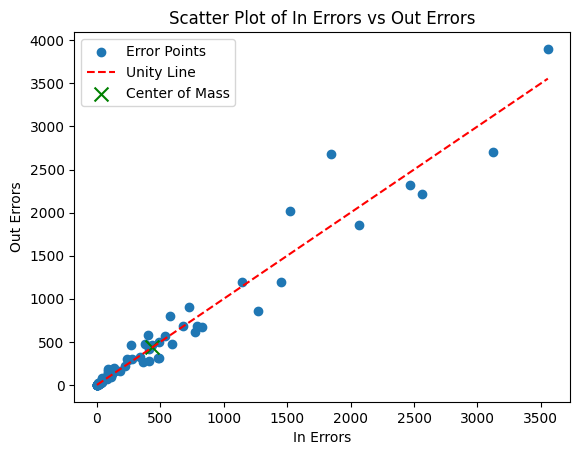

In [16]:
in_errors = l_al_errors + r_ar_errors / 2
out_errors = l_ar_errors + r_al_errors / 2

import matplotlib.pyplot as plt

plt.scatter(in_errors, out_errors, label='Error Points')
plt.plot([min(in_errors), max(in_errors)], [min(in_errors), max(in_errors)], 'r--', label='Unity Line')

# Calculate and plot the center of mass
center_of_mass_x = np.mean(in_errors)
center_of_mass_y = np.mean(out_errors)
plt.scatter(center_of_mass_x, center_of_mass_y, color='green', label='Center of Mass', s=100, marker='x')

plt.xlabel('In Errors')
plt.ylabel('Out Errors')
plt.title('Scatter Plot of In Errors vs Out Errors')
plt.legend()
plt.show()